In [1]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from pydrake.solvers import MathematicalProgram, Solve

from underactuated import running_as_notebook
from underactuated.quadrotor2d import Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()

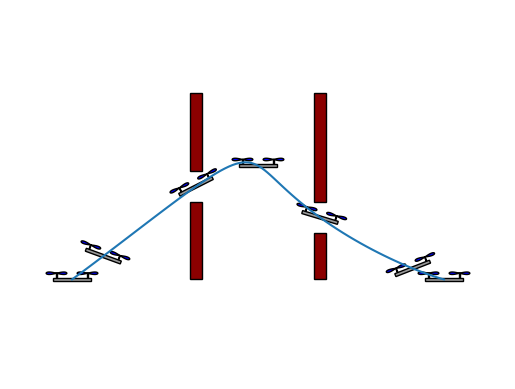

In [3]:
class PPTrajectory:
    def __init__(self, sample_times, num_vars, degree, continuity_degree):
        self.sample_times = sample_times
        self.n = num_vars
        self.degree = degree

        self.prog = MathematicalProgram()
        self.coeffs = []
        for i in range(len(sample_times)):
            self.coeffs.append(
                self.prog.NewContinuousVariables(num_vars, degree + 1, "C")
            )
        self.result = None

        # Add continuity constraints
        for s in range(len(sample_times) - 1):
            trel = sample_times[s + 1] - sample_times[s]
            coeffs = self.coeffs[s]
            for var in range(self.n):
                for deg in range(continuity_degree + 1):
                    # Don't use eval here, because I want left and right
                    # values of the same time
                    left_val = 0
                    for d in range(deg, self.degree + 1):
                        left_val += (
                            coeffs[var, d]
                            * np.power(trel, d - deg)
                            * math.factorial(d)
                            / math.factorial(d - deg)
                        )
                    right_val = self.coeffs[s + 1][var, deg] * math.factorial(deg)
                    self.prog.AddLinearConstraint(left_val == right_val)

        # Add cost to minimize highest order terms
        for s in range(len(sample_times) - 1):
            self.prog.AddQuadraticCost(
                np.eye(num_vars),
                np.zeros((num_vars, 1)),
                self.coeffs[s][:, -1],
            )

    def eval(self, t, derivative_order=0):
        if derivative_order > self.degree:
            return 0

        s = 0
        while s < len(self.sample_times) - 1 and t >= self.sample_times[s + 1]:
            s += 1
        trel = t - self.sample_times[s]

        if self.result is None:
            coeffs = self.coeffs[s]
        else:
            coeffs = self.result.GetSolution(self.coeffs[s])

        deg = derivative_order
        val = 0 * coeffs[:, 0]
        for var in range(self.n):
            for d in range(deg, self.degree + 1):
                val[var] += (
                    coeffs[var, d]
                    * np.power(trel, d - deg)
                    * math.factorial(d)
                    / math.factorial(d - deg)
                )

        return val

    def add_constraint(self, t, derivative_order, lb, ub=None):
        """Adds a constraint of the form d^deg lb <= x(t) / dt^deg <= ub."""
        if ub is None:
            ub = lb

        assert derivative_order <= self.degree
        val = self.eval(t, derivative_order)
        self.prog.AddLinearConstraint(val, lb, ub)

    def generate(self):
        self.result = Solve(self.prog)
        assert self.result.is_success()


tf = 3
zpp = PPTrajectory(
    sample_times=np.linspace(0, tf, 6),
    num_vars=2,
    degree=5,
    continuity_degree=4,
)
zpp.add_constraint(t=0, derivative_order=0, lb=[0, 0])
zpp.add_constraint(t=0, derivative_order=1, lb=[0, 0])
zpp.add_constraint(t=0, derivative_order=2, lb=[0, 0])
zpp.add_constraint(t=1, derivative_order=0, lb=[2, 1.5])
zpp.add_constraint(t=2, derivative_order=0, lb=[4, 1])
zpp.add_constraint(t=tf, derivative_order=0, lb=[6, 0])
zpp.add_constraint(t=tf, derivative_order=1, lb=[0, 0])
zpp.add_constraint(t=tf, derivative_order=2, lb=[0, 0])
zpp.generate()

if False:  # Useful for debugging
    t = np.linspace(0, tf, 100)
    z = np.zeros((2, len(t)))
    knots = np.zeros((2, len(zpp.sample_times)))
    fig, ax = plt.subplots(zpp.degree + 1, 1)
    for deg in range(zpp.degree + 1):
        for i in range(len(t)):
            z[:, i] = zpp.eval(t[i], deg)
        for i in range(len(zpp.sample_times)):
            knots[:, i] = zpp.eval(zpp.sample_times[i], deg)
        ax[deg].plot(t, z.transpose())
        ax[deg].plot(zpp.sample_times, knots.transpose(), ".")
        ax[deg].set_xlabel("t (sec)")
        ax[deg].set_ylabel("z deriv " + str(deg))

fig, ax = plt.subplots()

t = np.linspace(0, tf, 100)
z = np.zeros((2, len(t)))

for i in range(len(t)):
    z[:, i] = zpp.eval(t[i])
ax.plot(z[0, :], z[1, :])

for t in np.linspace(0, tf, 7):
    x = zpp.eval(t)
    xddot = zpp.eval(t, 2)
    theta = np.arctan2(-xddot[0], (xddot[1] + 9.81))
    v = Quadrotor2DVisualizer(ax=ax)
    context = v.CreateDefaultContext()
    v.get_input_port(0).FixValue(context, [x[0], x[1], theta, 0, 0, 0])
    v.draw(context)

# Draw the (imaginary) obstacles
ax.fill(
    2 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    1.25 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.fill(
    2 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    1.75 + 1.25 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.fill(
    4 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    0.75 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.fill(
    4 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    1.25 + 1.75 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.set_xlim([-1, 7])
ax.set_ylim([-0.25, 3])
ax.set_title("");